# Cart endgame

## Import and load the original data

In [158]:
import sys
sys.path.insert(1, '../') 
from utils.loader import Loader

import pandas as pd
from sklearn import tree
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.decomposition import PCA,TruncatedSVD
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import chi2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import prince
import numpy as np

In [159]:
data = Loader.load_all()['original']
label_encoder = LabelEncoder()

c:\Users\lingf\Desktop\SRC\Cars_Price_Prediction\CART\..\utils\loader.py:97: DtypeWarning: Columns (120) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path,
c:\Users\lingf\Desktop\SRC\Cars_Price_Prediction\CART\..\utils\loader.py:97: DtypeWarning: Columns (120) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path,
c:\Users\lingf\Desktop\SRC\Cars_Price_Prediction\CART\..\utils\loader.py:109: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original ob

### Describe some columns
A more detailed version of the dataset can be found in the DataDescription.ipynb

In [160]:
data.select_dtypes(include=['category'])

,color,brand,model,version,fuelType,bodyTypeId,transmissionTypeId,province,environmentalLabel,jato_classification,...,Acabado Exterior_Pintura,Acabado Exterior_Rueda,AC_Zones,AC_Type,Metodo_Apertura,Tipo_Faro,interior_clock,arm_suppport_front,arm_suppport_back,price_categ
idx,,,,,,,,,,,,,,,,,,,,,
0,Negro,MAZDA,MX-5,Active 1.8,Gasolina,Cabrio,Manual,Ciudad Real,C,B1,...,pintura solida,no tiene,MONOZONA,STANDARD,Mando a distancia,Otro,regular,caja integrada,no tiene,Bajo
1,Rojo (*TLV*),OPEL,Cabrio,1.4 T SS Excellence,Gasolina,Cabrio,Manual,Toledo,C,B1,...,pintura solida,no tiene,BIZONA,AUTO,Mando a distancia,Otro,no tiene,Tiene,no tiene,Bajo
2,Negro,PORSCHE,911,Turbo Coupe,Gasolina,Coupe,Automatico,Barcelona,NaN,S4,...,pintura metalizada,no tiene,BIZONA,AUTO,Mando a distancia,Xenón,no tiene,Tiene,no tiene,Medio-bajo
3,Rosa,FIAT,500,laPrima 31 320km 85kW 118CV,Eléctrico,Berlina,Automatico,Barcelona,0,L1,...,pintura metalizada,no tiene,MONOZONA,AUTO,Tarjeta/llave inteligente,LED,no tiene,Tiene,no tiene,Bajo
4,Blanco,CUPRA,León,1.5 eTSI 110kW 150CV DSG,Híbrido,Berlina,Automatico,Granada,ECO,S1,...,pintura solida,no tiene,TRIZONA,AUTO,Tarjeta/llave inteligente,LED,no tiene,Tiene,Tiene,Bajo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165432,Rojo,HYUNDAI,i30,CW 1.6 CRDi 81kW 110CV BlueDrive Go,Diésel,Familiar,Manual,Badajoz,C,M2,...,pintura metalizada,rueda repuesto llanta acero menor tamaño resto,BIZONA,AUTO,Mando a distancia,Otro,no tiene,Tiene,Tiene,Bajo
165433,Negro,AUDI,A1,Sportback Advanced 25 TFSI 70kW 95CV,Gasolina,Berlina,Manual,Valencia,NaN,M1,...,pintura bicolor solida,no tiene,MONOZONA,STANDARD,Mando a distancia,Otro,no tiene,no tiene,no tiene,Bajo
165434,Blanco,NISSAN,QASHQAI,DIGT 103kW 140CV mHEV 4x2 Acenta,Híbrido,SUV,Manual,Granada,C,M1,...,pintura solida,no tiene,BIZONA,AUTO,Tarjeta/llave inteligente,LED,no tiene,Tiene,Tiene,Bajo


In [161]:
def hist_plot(arr, n_bins, title = "hist_plot", x_label = "price", y_label="frecuency"):
    plt.figure(figsize=(8, 6))
    sns.histplot(arr, kde=True, bins=n_bins)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

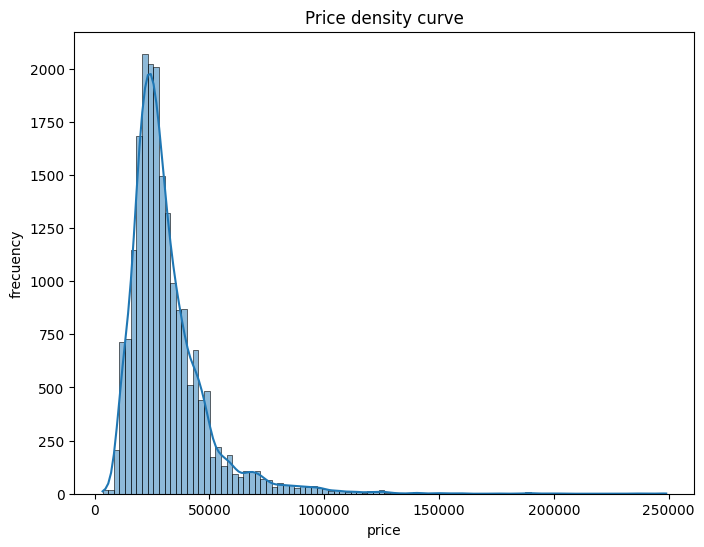

In [162]:
hist_plot(data[data["fuelType"]=="Híbrido"]["price"], n_bins=100, title='Price density curve')

In [163]:
precios_electricos = data[data["fuelType"]=="Eléctrico"]["price"]
print(precios_electricos)

idx
3         27500
7         33150
10        31900
14        25900
18        81900
          ...  
164732    26000
164840    13750
164991    14500
165059    14200
165299     9800
Name: price, Length: 6591, dtype: int64


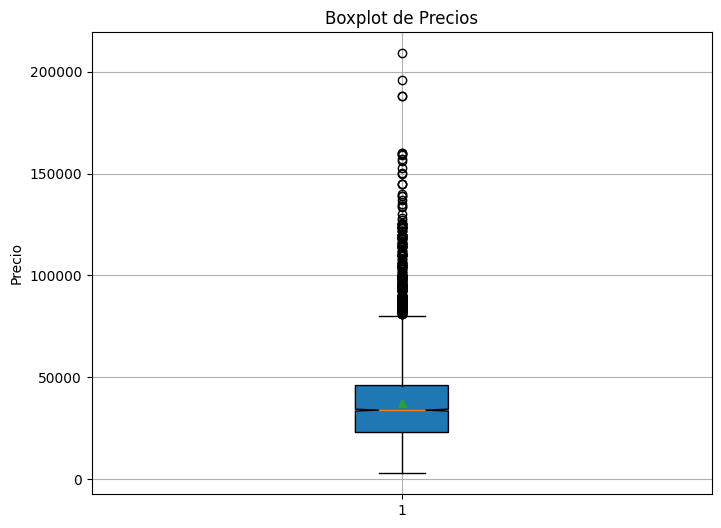

In [164]:
plt.figure(figsize=(8, 6))
plt.boxplot(precios_electricos, notch=True, vert=True, patch_artist=True, showmeans=True)
plt.title('Boxplot de Precios')
plt.ylabel('Precio')
plt.grid(True)
plt.show()

The related outliers were checked manually throught the data source, and we could confirmed that they are not outliers

In [165]:
Q1 = data['price'].quantile(0.25)
Q2 = data['price'].quantile(0.5)  # Esta es la mediana
Q3 = data['price'].quantile(0.75)
IQR = Q3 - Q1

upper_whisker = (Q3 + 1.5 * IQR)
print(upper_whisker)

data[data["fuelType"] == "Eléctrico"][data["price"]>upper_whisker][["price", "brand"]].sort_values(by='price', ascending=False)
#data = data[data["price"]<upper_whisker]

52515.0


C:\Users\lingf\AppData\Local\Temp\ipykernel_21064\4040790187.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data[data["fuelType"] == "Eléctrico"][data["price"]>upper_whisker][["price", "brand"]].sort_values(by='price', ascending=False)


,price,brand
idx,,
28269,209000,MASERATI
85726,196000,MASERATI
134773,188000,MERCEDES-BENZ
144182,188000,MERCEDES-BENZ
21981,159900,PORSCHE
...,...,...
148354,52600,MINI
40482,52600,PEUGEOT
34631,52600,BMW


## Separate the DF in fuelType Categories

We split the dataframe into the categories so in the PCA or CA, we don't discart columns because of the most popular classes

In [166]:
def split_fuel_type(data:pd.DataFrame) -> dict:
    ret={}
    ret["Eléctrico"] = data[data["fuelType"] == "Eléctrico"]
    ret["Combustion"] = data[(data["fuelType"] == "Gasolina") | (data["fuelType"] == "Diésel")]
    ret["Híbrido"] = data[data["fuelType"] == "Híbrido"]
    ret["Híbrido enchufable"] = data[data["fuelType"] == "Híbrido enchufable"]
    ret["Gas"] = data[(data["fuelType"] == "Gas licuado (GLP)") | (data["fuelType"] == "Gas natural (CNG)")]
    return ret

In [167]:
data = split_fuel_type(data)

## Data process functions

In [168]:
def fill_na_with_mode(df, column_name, inplace=False):
    if column_name in df.columns:
        mode_value = df[column_name].mode().iloc[0]
        df[column_name] = df[column_name].fillna(mode_value, inplace=inplace)
    else:
        print(f"La columna '{column_name}' no existe en el DataFrame.")
    return df

def impute_with_linear_regression(data, x_columns, y_column):
    df_with_target = data.dropna(subset=[y_column])
    df_without_target = data[data[y_column].isna()]
    
    X_train = df_with_target[x_columns]
    y_train = df_with_target[y_column]
    X_test = df_without_target[x_columns]
    
    model = LinearRegression()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_train)
    epsilon = np.finfo(np.float64).eps
    mape = np.mean(np.abs((y_train - y_pred) / (y_train + epsilon))) * 100
    print(f"Regression mape {x_columns} -> {y_column}: {mape}%")
    if not X_test.empty:
        predicted_values = model.predict(X_test)
        data.loc[data[y_column].isna(), y_column] = predicted_values
    return data

def remove_redundand_columns(df:pd.DataFrame )->pd.DataFrame:
    for column in df.columns: #Remove redundant columns
        unique_values = df[column].dropna().unique() 
        if len(unique_values) == 1:
            df = df.drop(column, axis=1)
    return df

def __impute_categorical_mode(df, X, Y):
    # Agrupar por las columnas X y calcular el valor más común (moda) en la columna Y para cada grupo
    modes = df.groupby(X,observed=False)[Y].agg(lambda x: x.dropna().mode()[0] if not x.dropna().empty else None, ).reset_index()
    modes.rename(columns={Y: 'Mode'}, inplace=True)
    
    # Unir el DataFrame original con los modos encontrados para facilitar la imputación
    df = df.merge(modes, on=X, how='left')
    
    # Imputar los valores NaN en Y usando el valor más común de su grupo
    df[Y] = df.apply(lambda row: row['Mode'] if pd.isna(row[Y]) else row[Y], axis=1)

    # Eliminar la columna auxiliar 'Mode' añadida para la imputación
    df.drop('Mode', axis=1, inplace=True)
    
    return df

def impute_categorical_mode(df, X, Y):
    for i in range(len(X)):
        df = __impute_categorical_mode(df, X, Y)
        X.pop(len(X)-1)
    df[Y] = df[Y].fillna("unkown") #If is a unique car
    return df

## Feature selection functions

In [169]:
def CA (categorical_columns, col_x, col_y):
    contingency_table = pd.crosstab(categorical_columns[col_x], categorical_columns[col_y])

    P = contingency_table / contingency_table.values.sum()

    # Calcular los perfiles de fila y columna (matrices D_r y D_c)
    D_r = np.diag(1 / P.sum(axis=1))
    D_c = np.diag(1 / P.sum(axis=0))

    # Calcular la matriz S (correspondencia ajustada)
    S = np.sqrt(D_r).dot(P).dot(np.sqrt(D_c))

    # Aplicar SVD
    svd = TruncatedSVD(n_components=2)
    svd.fit(S)
    row_coordinates = svd.transform(S)  # Coordenadas de las filas
    col_coordinates = svd.components_.T  # Coordenadas de las columnas

    # Visualización
    plt.figure(figsize=(8, 8))
    for i, label in enumerate(contingency_table.index):
        plt.scatter(row_coordinates[i, 0], row_coordinates[i, 1], color='blue')
        plt.text(row_coordinates[i, 0], row_coordinates[i, 1], f'{label}', color='blue', ha='right', va='bottom')
    for i, label in enumerate(contingency_table.columns):
        plt.scatter(col_coordinates[i, 0], col_coordinates[i, 1], color='red', marker='^')
        plt.text(col_coordinates[i, 0], col_coordinates[i, 1], f'{label}', color='red', ha='left', va='top')

    plt.xlabel('Componente 1')
    plt.ylabel('Componente 2')
    plt.title('Gráfico de Análisis de Correspondencias')
    plt.grid(True)
    plt.show()

In [170]:
def chi_square_test(categorical_columns: pd.DataFrame, column_y: str):
    encoded_df = categorical_columns.copy()
    for col in categorical_columns.columns:
        encoded_df[col] = label_encoder.fit_transform(encoded_df[col])

    X = encoded_df.drop(columns=[column_y])
    y = encoded_df[column_y]

    # Realizar la prueba de chi-cuadrado
    chi2_stat, p_values = chi2(X, y)

    # Crear un DataFrame para mostrar los resultados
    results = pd.DataFrame({
        'Feature': X.columns,
        'Chi2 Stat': chi2_stat,
        'p-value': p_values
    })

    # Ordenar los resultados por el valor p
    results.sort_values('p-value', inplace=True)

    plt.figure(figsize=(10, 6))
    plt.barh(results['Feature'], results['p-value'], color='skyblue')
    plt.xlabel('p-value')
    plt.ylabel('Features')
    plt.title('Chi-Square Test Results')
    plt.gca().invert_yaxis()  # Invertir el eje y para que la característica con menor p-value esté arriba
    plt.show()

    # Mostrar el DataFrame de resultados
    return results

In [171]:
def chi_square_filter(categorical_columns: pd.DataFrame, column_y: str, p_value_filter: float) -> pd.DataFrame:
    result = chi_square_test(categorical_columns=categorical_columns, column_y=column_y)
    columns = list(result[ result["p-value"] < p_value_filter ]["Feature"])
    columns.append("price_categ")
    return categorical_columns[ columns ]

# Electric cars

## PCA Eléctrico

In [172]:
def get_electric_numerical_columns (data: pd.DataFrame) -> pd.DataFrame:
    numerical_columns = data.select_dtypes(include=['number'])
    numerical_columns.drop(columns=[ "car_id", "electricFeatures.maxPower_CV"], inplace=True) # electricFeatures.maxPower_CV is = power_cv (Duplicated colums)

    #if all the values of the numerical columns is 0, we remove the column
    cols_to_drop = numerical_columns.columns[(numerical_columns == 0).all()]
    numerical_columns = numerical_columns.drop(cols_to_drop, axis=1)

    #Remove the column with all NAs
    max_nans = 6586
    thresh = numerical_columns.shape[0] - max_nans

    numerical_columns.dropna(axis=1, thresh=thresh+1, inplace=True)
    return numerical_columns

In [173]:
numerical_columns = get_electric_numerical_columns(data["Eléctrico"])

In [174]:
def fill_electric_numerical_columns(numerical_columns: pd.DataFrame) -> pd.DataFrame:
    #fill the elemental columns that has a minor amount of missing data with the mode
    numerical_columns = fill_na_with_mode(numerical_columns, "dimensions.length")
    numerical_columns = fill_na_with_mode(numerical_columns, "dimensions.height")
    numerical_columns = fill_na_with_mode(numerical_columns, "electricFeatures.maximumBatteryKWH_kWh")
    numerical_columns = fill_na_with_mode(numerical_columns, "electricFeatures.onboardCharger_kW")
    numerical_columns = fill_na_with_mode(numerical_columns, "electricFeatures.range_KM")

    #fill the missing data witch regression, the parameters were based on the relation matrix 
    numerical_columns = impute_with_linear_regression(data=numerical_columns, x_columns=["dimensions.length", "dimensions.height"], y_column="dimensions.width")
    numerical_columns = impute_with_linear_regression(data=numerical_columns, x_columns=["dimensions.length", "dimensions.height", "dimensions.width"], y_column="trunkCapacityInLiters")
    numerical_columns = impute_with_linear_regression(data=numerical_columns, x_columns=["power_cv", "power_kw"], y_column="maxSpeed")
    numerical_columns = impute_with_linear_regression(data=numerical_columns, x_columns=["power_cv", "power_kw", "maxSpeed"], y_column="acceleration")
    numerical_columns = impute_with_linear_regression(data=numerical_columns, x_columns=["power_cv", "power_kw", "maxSpeed"], y_column="acceleration")
    numerical_columns = impute_with_linear_regression(data=numerical_columns, x_columns=["Llantas_Diametro_cm", "power_kw"], y_column="max_torque_nm")
    numerical_columns = impute_with_linear_regression(data=numerical_columns, x_columns=["electricFeatures.maximumBatteryKWH_kWh", "power_kw", "dimensions.length", "dimensions.height", "dimensions.width"], y_column="electricFeatures.combinedConsumption_kWh/")
    numerical_columns = impute_with_linear_regression(data=numerical_columns, x_columns=["electricFeatures.maximumBatteryKWH_kWh", "electricFeatures.combinedConsumption_kWh/", "power_kw"], y_column="electricFeatures.range_KM")
    numerical_columns.dropna(axis=1, inplace=True)
    return numerical_columns

In [175]:
numerical_columns = fill_electric_numerical_columns(numerical_columns=numerical_columns)

Regression mape ['dimensions.length', 'dimensions.height'] -> dimensions.width: 1.6468475373043994%
Regression mape ['dimensions.length', 'dimensions.height', 'dimensions.width'] -> trunkCapacityInLiters: 16.91508204296949%
Regression mape ['power_cv', 'power_kw'] -> maxSpeed: 5.689473571028928%
Regression mape ['power_cv', 'power_kw', 'maxSpeed'] -> acceleration: 13.035625391285748%
Regression mape ['power_cv', 'power_kw', 'maxSpeed'] -> acceleration: 11.85488371952156%
Regression mape ['Llantas_Diametro_cm', 'power_kw'] -> max_torque_nm: 17.854083487783583%
Regression mape ['electricFeatures.maximumBatteryKWH_kWh', 'power_kw', 'dimensions.length', 'dimensions.height', 'dimensions.width'] -> electricFeatures.combinedConsumption_kWh/: 17.20475510968712%
Regression mape ['electricFeatures.maximumBatteryKWH_kWh', 'electricFeatures.combinedConsumption_kWh/', 'power_kw'] -> electricFeatures.range_KM: 16.16138222681962%


In [176]:
correlation_matrix = numerical_columns.corr()["price"]
print(correlation_matrix)

price                                        1.000000
km                                          -0.343331
year                                         0.459700
doors                                        0.092279
seatingCapacity                              0.257532
trunkCapacityInLiters                        0.301739
maxSpeed                                     0.655830
acceleration                                -0.582307
power_cv                                     0.709338
power_kw                                     0.712126
max_torque_nm                                0.677488
speakers                                     0.294090
dimensions.width                             0.689372
dimensions.height                            0.055209
dimensions.length                            0.613427
Numero_Testigos                              0.183137
Llantas_Diametro_cm                          0.633856
electricFeatures.range_KM                    0.600411
electricFeatures.maximumBatt

In [177]:
scaler = StandardScaler()
df_scaled  = scaler.fit_transform(numerical_columns)

pca = PCA(n_components=2)
principal_components = pca.fit_transform(df_scaled)
df_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

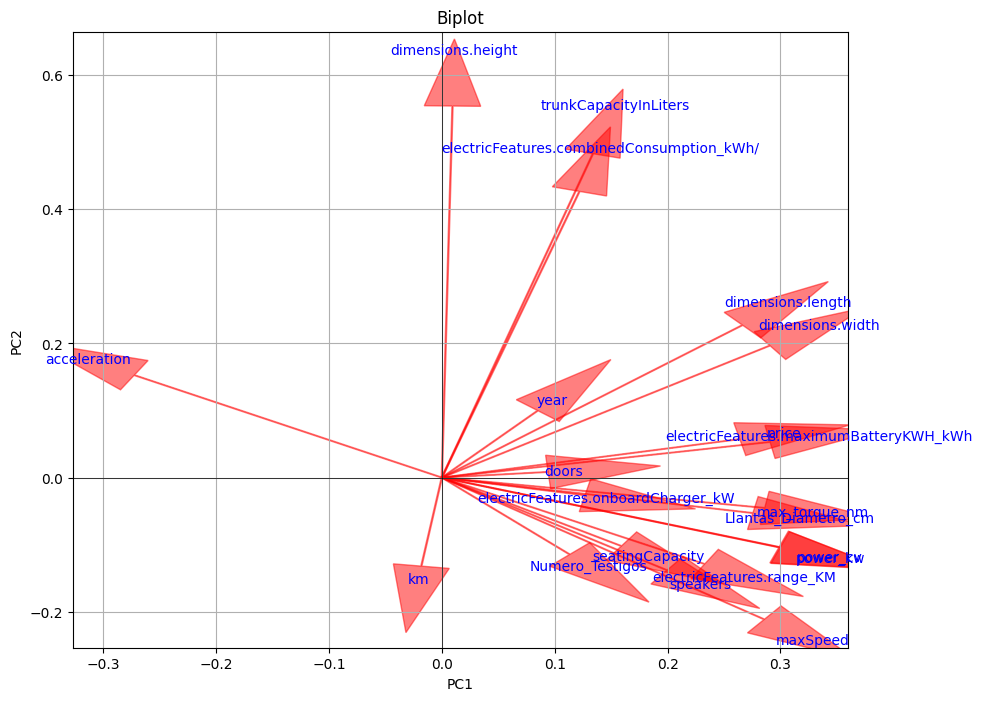

In [178]:
def biplot(score, coeff, labels=None):
    plt.figure(figsize=(10, 8))
    origin = [0, 0]  # Origen de las flechas

    # Dibujar las flechas
    for i in range(len(coeff)):
        plt.arrow(origin[0], origin[1], coeff[i,0], coeff[i,1], color='r', alpha=0.5, head_width=0.05, head_length=0.1)
        if labels is not None:
            plt.text(coeff[i,0]*1.15, coeff[i,1]*1.15, labels[i], color='blue', ha='center', va='center')

    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("Biplot")
    plt.grid(True)
    plt.axhline(0, color='black',linewidth=0.5)
    plt.axvline(0, color='black',linewidth=0.5)
    plt.xlim(min(coeff[:,0])*1.2, max(coeff[:,0])*1.2)
    plt.ylim(min(coeff[:,1])*1.2, max(coeff[:,1])*1.2)
    plt.show()

# Llamada a la función biplot
biplot(principal_components, np.transpose(pca.components_[0:2, :]), labels=numerical_columns.columns)

## Test CART regression trees with only numerical variables

In [179]:
X = numerical_columns.drop(columns="price")
y = numerical_columns["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

tree_model = DecisionTreeRegressor(random_state=42)
tree_model.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

In [180]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Realizar predicciones sobre el conjunto de prueba
y_pred = tree_model.predict(X_test)

# Calcular el MAPE
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

Mean Absolute Percentage Error (MAPE): 10.39%


## CA Electrico

In [181]:
def get_electric_categorical_columns(df: pd.DataFrame) -> pd.DataFrame:
    ret = df.select_dtypes(include=['category'])
    ret = ret.drop(columns=["environmentalLabel"]) #All of the cars of this dataframes are electrical which implies 0 emission
    ret = remove_redundand_columns(ret)
    ret = impute_categorical_mode(df=ret, X=["brand", "model"], Y="version")
    ret = impute_categorical_mode(df=ret, X=["brand", "model"], Y="jato_classification")
    ret = impute_categorical_mode(df=ret, X=["brand", "model", "traction"], Y="brakes")
    ret = impute_categorical_mode(df=ret, X=["brand", "model", "traction","brakes"], Y="front_suspension")
    ret = impute_categorical_mode(df=ret, X=["brand", "model", "traction","brakes"], Y="rear_suspension")
    return ret

In [182]:
categorical_columns = get_electric_categorical_columns(data["Eléctrico"])
categorical_columns.columns

Index(['color', 'brand', 'model', 'version', 'bodyTypeId',
       'transmissionTypeId', 'province', 'jato_classification', 'traction',
       'brakes', 'front_suspension', 'rear_suspension',
       'Acabado Exterior_Alerón', 'Acabado Exterior_Cristales',
       'Acabado Exterior_Faldones', 'Acabado Exterior_Pintura',
       'Acabado Exterior_Rueda', 'AC_Zones', 'AC_Type', 'Metodo_Apertura',
       'Tipo_Faro', 'interior_clock', 'arm_suppport_front',
       'arm_suppport_back', 'price_categ'],
      dtype='object')

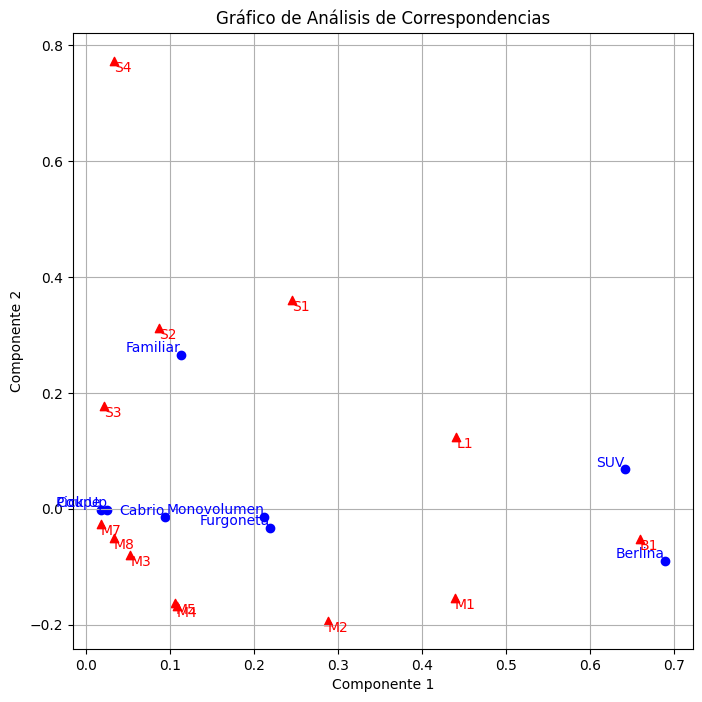

In [183]:
CA(categorical_columns=categorical_columns, col_x="bodyTypeId", col_y="jato_classification")

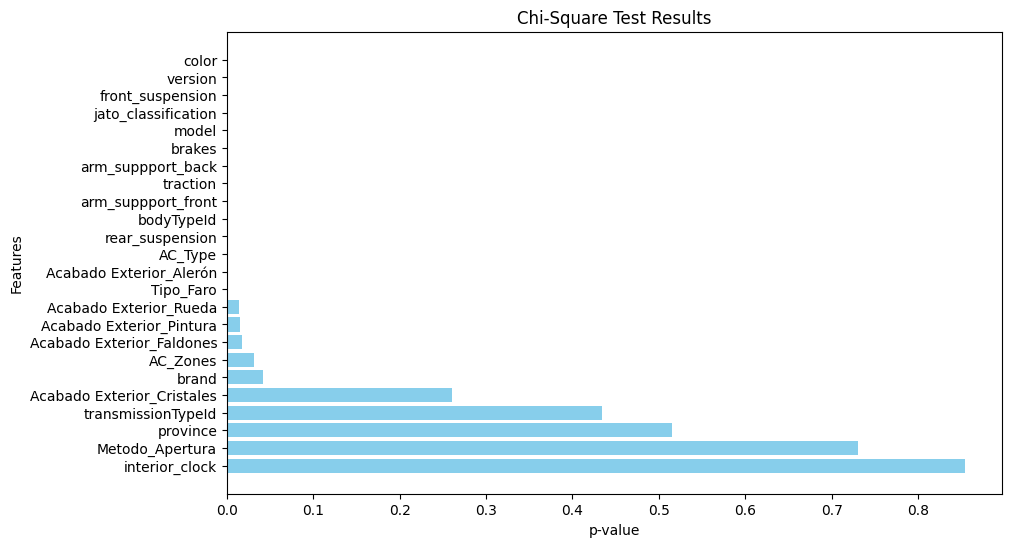

In [184]:
categorical_columns = chi_square_filter(categorical_columns, "price_categ", p_value_filter=0.05)

## Test CART tree classifier with only categorical values

In [185]:
for col in categorical_columns.columns:
    categorical_columns[col] = label_encoder.fit_transform(categorical_columns[col])

# Preparar los datos
X = categorical_columns.drop(columns=["price_categ"])
Y = categorical_columns["price_categ"]

# Dividir los datos en entrenamiento y prueba
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Crear el modelo de árbol de decisión
tree_model = DecisionTreeClassifier(random_state=42, max_depth=4)

# Entrenar el modelo
tree_model.fit(X_train, Y_train)

# Predecir las etiquetas del conjunto de prueba
Y_pred = tree_model.predict(X_test)

# Calcular la precisión
accuracy = accuracy_score(Y_test, Y_pred)
print(f"La precisión del modelo es: {accuracy:.2f}")

La precisión del modelo es: 0.99


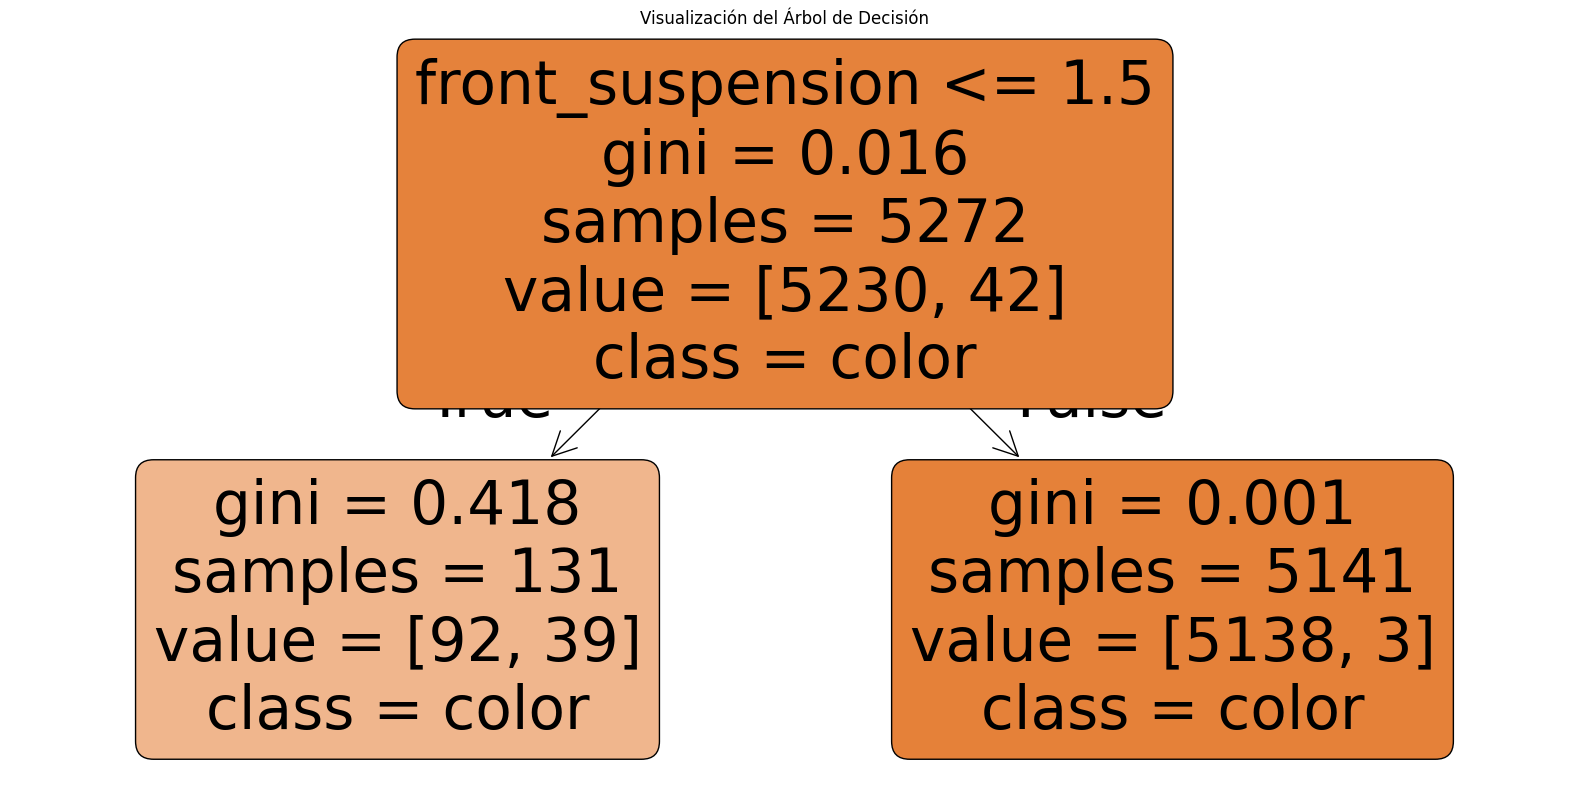

In [186]:
plt.figure(figsize=(20,10))

# Dibujar el árbol de decisión
plot_tree(tree_model, 
          filled=True, 
          rounded=True, 
          class_names=X_train.columns, 
          feature_names=X.columns, 
          max_depth=3)  # Puedes ajustar la profundidad para una mejor visualización o quitar este parámetro para mostrar todo el árbol
plt.title('Visualización del Árbol de Decisión')
plt.show()

## Combustion

In [ ]:
def drop_columns_full_nan(data: pd.DataFrame) -> pd.DataFrame:
    #Remove the column that only contain NAs
    cols_to_drop = data.columns[data.isna().all()]
    data = data.drop(cols_to_drop, axis=1)
    return data

def get_combustion_numerical_columns (data: pd.DataFrame) -> pd.DataFrame:
    numerical_columns = data.select_dtypes(include=['number'])

    #if all the values of the numerical columns is 0, we remove the column
    cols_to_drop = numerical_columns.columns[(numerical_columns == 0).all()]
    numerical_columns = numerical_columns.drop(cols_to_drop, axis=1)
    return numerical_columns

def fill_combustion_numerical_columns(numerical_columns: pd.DataFrame) -> pd.DataFrame:
    #fill the elemental columns that has a minor amount of missing data with the mode
    numerical_columns = fill_na_with_mode(numerical_columns, "dimensions.length")
    numerical_columns = fill_na_with_mode(numerical_columns, "dimensions.height")
    numerical_columns = fill_na_with_mode(numerical_columns, "Llantas_Diametro_cm")

    #fill the missing data witch regression, the parameters were based on the relation matrix 
    numerical_columns = impute_with_linear_regression(data=numerical_columns, x_columns=["dimensions.length", "dimensions.height"], y_column="dimensions.width")
    numerical_columns = impute_with_linear_regression(data=numerical_columns, x_columns=["dimensions.length", "dimensions.height", "dimensions.width"], y_column="trunkCapacityInLiters")
    numerical_columns = impute_with_linear_regression(data=numerical_columns, x_columns=["power_cv", "power_kw"], y_column="maxSpeed")
    numerical_columns = impute_with_linear_regression(data=numerical_columns, x_columns=["power_cv", "power_kw", "maxSpeed"], y_column="acceleration")
    numerical_columns = impute_with_linear_regression(data=numerical_columns, x_columns=["power_cv", "power_kw", "maxSpeed"], y_column="acceleration")
    numerical_columns = impute_with_linear_regression(data=numerical_columns, x_columns=["Llantas_Diametro_cm", "power_kw"], y_column="max_torque_nm")
    numerical_columns.dropna(axis=1, inplace=True)
    return numerical_columns

def get_combustion_categorical_columns(df: pd.DataFrame) -> pd.DataFrame:
    ret = df.select_dtypes(include=['category'])
    ret = remove_redundand_columns(ret)
    ret = impute_categorical_mode(df=ret, X=["brand", "model"], Y="version")
    ret = impute_categorical_mode(df=ret, X=["brand", "model"], Y="jato_classification")
    ret = impute_categorical_mode(df=ret, X=["brand", "model", "traction"], Y="brakes")
    ret = impute_categorical_mode(df=ret, X=["brand", "model", "traction","brakes"], Y="front_suspension")
    ret = impute_categorical_mode(df=ret, X=["brand", "model", "traction","brakes"], Y="rear_suspension")
    return ret


In [ ]:
# Quit all electric columns from data['Combustion']
pd.set_option('display.max_columns', None)
for column in data['Combustion'].columns:
    if column.startswith('electric'):
        data['Combustion'] = data['Combustion'].drop(columns=column)

In [ ]:
pd.set_option('display.max_rows', None)

# Drop all na columns 
data['Combustion'] = drop_columns_full_nan(data['Combustion'])

numerical_columns = get_combustion_numerical_columns(data['Combustion'])

# fill the missing data in numerical columns
numerical_columns = fill_combustion_numerical_columns(numerical_columns)

# Check amount of missing values
missing_values_num = numerical_columns.isnull().sum()
missing_values_num = missing_values_num[missing_values_num > 0]

data['Combustion'][numerical_columns.columns] = numerical_columns

# Check amount of missing values
missing_values = data['Combustion'].isnull().sum()
missing_values = missing_values[missing_values > 0]


correlation_matrix = numerical_columns.corr()
correlation_matrix = correlation_matrix.sort_values(by='price', ascending=False)

correlation_matrix
print(missing_values_num)
print(missing_values)
